# Classification: Instant Recognition with Caffe

In this example we'll classify an image with the bundled CaffeNet model (which is based on the network architecture of Krizhevsky et al. for ImageNet).

We'll compare CPU and GPU modes and then dig into the model to inspect features and the output.

### 1. Setup the net.

* First, set up Python, import `numpy`,'caffe',and `matplotlib`.

In [9]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')
import caffe
from google.protobuf import text_format
import caffe
import caffe.draw
from caffe.proto import caffe_pb2

* build net (produce deploy.prototxt,train.prototxt,val.prototxt,solver.prototxt)

In [10]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0),deploy = False):
    if deploy == True:
        conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group)
        return conv, L.ReLU(conv, in_place=True)
        
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=1),deploy = False):
    if deploy == True:
        fc = L.InnerProduct(bottom, num_output=nout)
        return fc, L.ReLU(fc, in_place=True)
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)


def datalayer(source,batchsize,phase=0):
    
    #if deploy == True:
    #    data = L.Input(shape=dict(dim=[10, 3, 227, 227]))
    #    return data,None
    data, label = L.Data(batch_size=batchsize, backend=P.Data.LMDB, source=source,include = dict(phase=phase),
                            transform_param=dict(mirror=(phase==0),crop_size = 227,mean_file='data/ilsvrc12/imagenet_mean.binaryproto'),ntop=2)
    return data,label 

def caffenet(source, batchsize,phase = 0, num_classes=1000,
             classifier_name='fc8', learn_all=False,deploy = False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    if deploy == True:
        n.data = L.Input(shape=dict(dim=[10, 3, 227, 227]))
    else:
        n.data,n.label = datalayer(source,batchsize,phase = phase)
    #param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4,deploy = deploy)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2,bias_filler=dict(type='constant', value=1),deploy = deploy)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1,deploy = deploy)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2,bias_filler=dict(type='constant', value=1),deploy = deploy)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2,bias_filler=dict(type='constant', value=1),deploy = deploy)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096,deploy = deploy)
    #if train:
    n.drop6 = fc7input = L.Dropout(n.relu6,dropout_param=dict(dropout_ratio=0.5), in_place=True)
    #else:
    fc7input = n.relu6
    n.fc7, n.relu7 = fc_relu(fc7input, 4096,deploy = deploy)
    #if train:
    n.drop7 = fc8input = L.Dropout(n.relu7,dropout_param=dict(dropout_ratio=0.5), in_place=True)
    #else:
    fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    if deploy == True:
        fc8 = L.InnerProduct(fc8input, num_output=num_classes)
    else:
        fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param, weight_filler=dict(type='gaussian', std=0.01),
                  bias_filler=dict(type='constant', value=0))
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    #if not train:
    #n.probs = L.Softmax(fc8)
    #if label is not None:
    #n.label = label

    if deploy == True:
        n.prob = L.Softmax(fc8)
    else:
        if phase == 1:
            n.accuracy = L.Accuracy(fc8, n.label,include = dict(phase=1))
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        
    
    
    return n.to_proto()


def solver(train_net_path, test_net_path, base_lr=0.01):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    #if test_net_path is not None:
    s.test_net.append(test_net_path)
    s.test_interval = 1000  # Test after every 1000 training iterations.
    s.test_iter.append(1000) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    #s.iter_size = 1
    
    s.max_iter = 50000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    #s.type = 'SGD'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 100000

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 20

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = 'examples/imagenet/snapshot/caffenet_train'
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    return s
    
train_net_path = 'examples/imagenet/train.prototxt'
test_net_path = 'examples/imagenet/val.prototxt'
sovler_path = 'examples/imagenet/testsolver.prototxt'
deploy_path = 'examples/imagenet/deploy.prototxt'
#if os.path.exists(train_net_path) == False:
    #!sudo touch 

with open(caffe_root + train_net_path, 'w') as f:
    f.write(str(caffenet('examples/imagenet/ilsvrc12_train_lmdb',64,phase = 0,num_classes = 10)))
    
with open(caffe_root + test_net_path, 'w') as f:
    f.write(str(caffenet('examples/imagenet/ilsvrc12_val_lmdb',50,phase = 1,num_classes = 10)))
    
with open(caffe_root + deploy_path, 'w') as f:
    f.write(str(caffenet('examples/imagenet/ilsvrc12_val_lmdb',50,num_classes = 10,deploy = True)))
    
with open(caffe_root + sovler_path, 'w') as f:
    f.write(str(solver(train_net_path,test_net_path,base_lr = 0.00001)))


In [11]:
#cat ../examples/imagenet/train.prototxt
path = caffe_root + train_net_path
!cat $path
path = caffe_root + sovler_path
!cat $path

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TRAIN
  }
  transform_param {
    mirror: true
    crop_size: 227
    mean_file: "data/ilsvrc12/imagenet_mean.binaryproto"
  }
  data_param {
    source: "examples/imagenet/ilsvrc12_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 1
    decay_mult: 1
  }
  param {
    lr_mult: 2
    decay_mult: 0
  }
  convolution_param {
    num_output: 96
    pad: 0
    kernel_size: 11
    group: 1
    stride: 4
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
      type: "constant"
      value: 0
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 2
  }
}
layer {
  name: "norm1"
  type: "LRN"
  bottom: "

In [12]:
# If possible,please ignore this and turn to Command for sudo ./buid
#!sudo ./build/tools/caffe  train --solver=$sovler_path

# 2.display the net.

Drawing net to ../examples/imagenet/visual.png


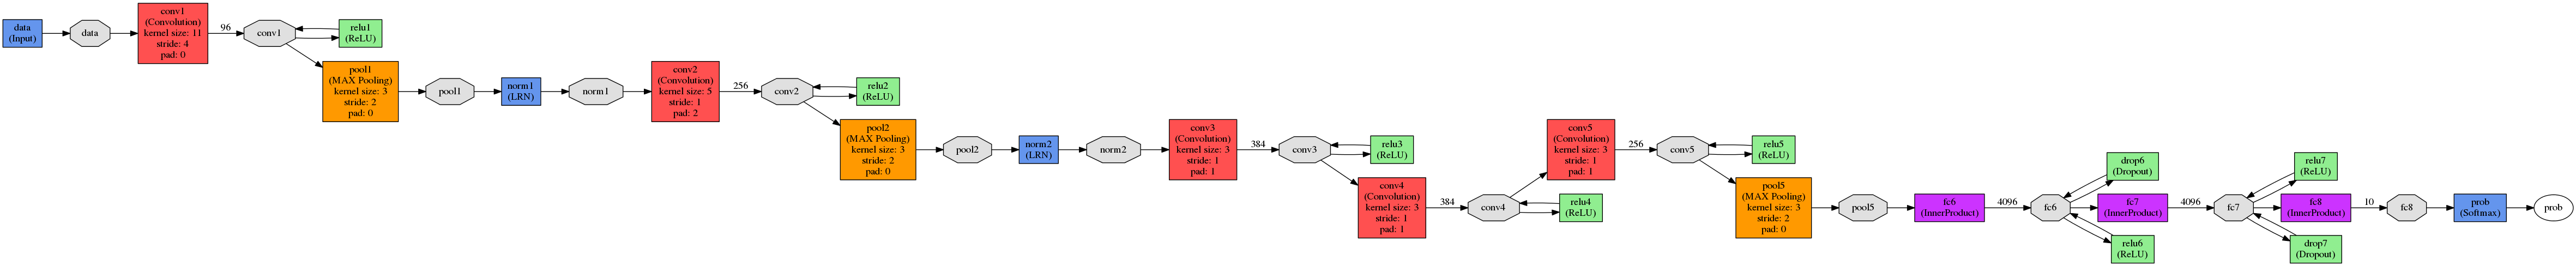

In [13]:
#prototxtpath = caffe_root + 'examples/imagenet/deploy.prototxt'
outpngpath = caffe_root + 'examples/imagenet/visual.png'

net = caffe_pb2.NetParameter()
text_format.Merge(open(caffe_root + deploy_path).read(),net)
print 'Drawing net to %s' % outpngpath
caffe.draw.draw_net_to_file(net,outpngpath,'LR')
from IPython.core.display import Image,display
display(Image(outpngpath))

### 3. Load net and set up input preprocessing

* Set Caffe to GPU mode and load the net from disk.

In [14]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [15]:
import os
if os.path.isfile(caffe_root + 'examples/imagenet/snapshot/caffenet_train_iter_10000.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


In [16]:
blob = caffe.proto.caffe_pb2.BlobProto()
data = open(caffe_root+'data/ilsvrc12/imagenet_mean.binaryproto' , 'rb' ).read()
blob.ParseFromString(data)
arr = np.array( caffe.io.blobproto_to_array(blob) )
out = arr[0]
np.save(caffe_root+'examples/imagenet/tree_mean.npy', out )

In [17]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()
model_def = caffe_root + deploy_path#'examples/imagenet/deploy.prototxt'
model_weights = caffe_root + 'examples/imagenet/snapshot/caffenet_train_iter_10000.caffemodel'
net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [18]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'examples/imagenet/tree_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


In [19]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

(3, 227, 227)


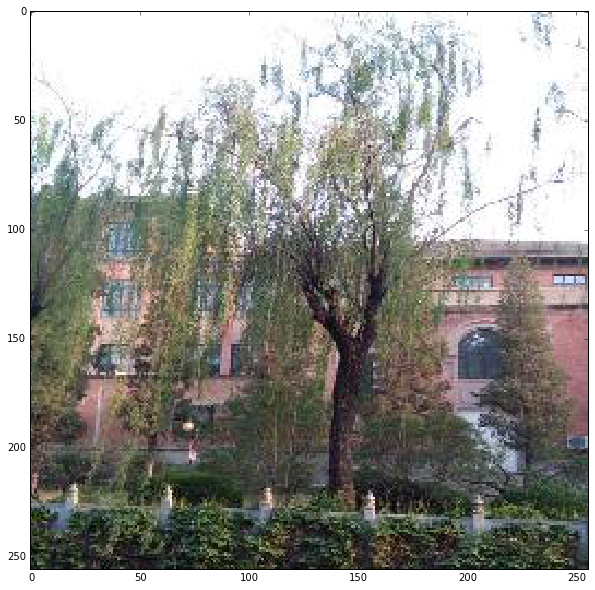

In [20]:
image = caffe.io.load_image('/home/jiangyy/Desktop/tree/val/00/valid_00_0000.jpg')
transformed_image = transformer.preprocess('data', image)
print transformed_image.shape
plt.imshow(image)

* Adorable! Let's classify it!

In [21]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

labels = ['柳树','毛白杨','雪松','银杏','梧桐','丁香','牡丹','其他']
Temp = output_prob.argmax()
if(Temp >= 7):
    Temp = 7
print 'output label:', labels[Temp]

predicted class is: 0
output label: 柳树


In [22]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

* First we'll look at the first layer filters, `conv1`

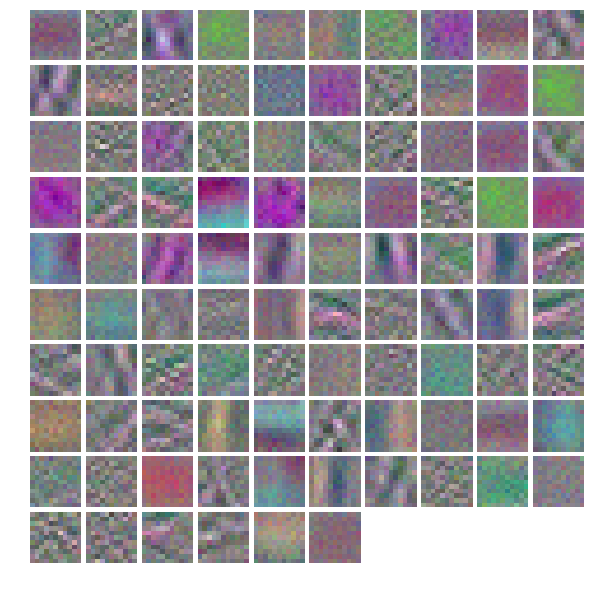

In [23]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

* The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

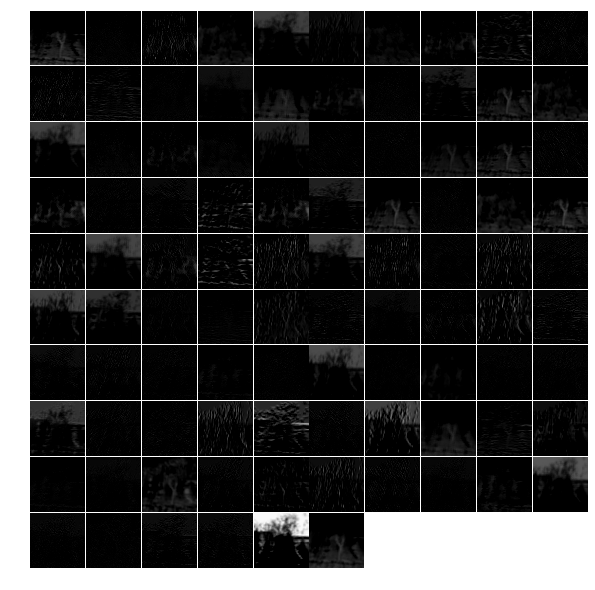

In [24]:
feat = net.blobs['conv1'].data[0, :96]
vis_square(feat)

# 5. Histogram statistics on different layers.

* Since we're dealing with four-dimensional data here, We need flatten it,
* In addition,histogram range depend on ranging of 98% of parameter. 

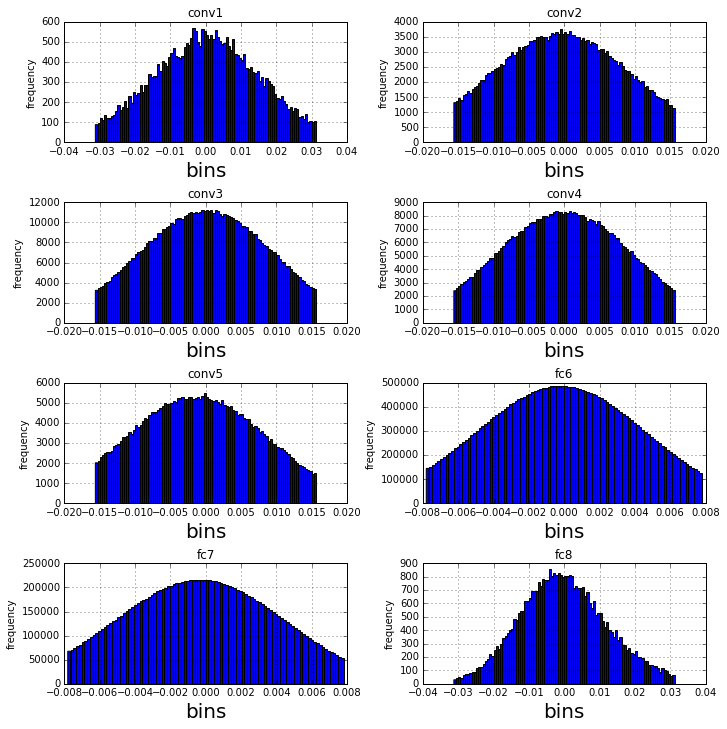

In [25]:
#sum = len(enumerate(net.params.iteritems()))
#print sum
#width = 2
#high = (sum + width - 1) / width
#print width,high
#print net.params.iteritems()
def GethistogramRange(X):
    min = -1.0
    max =  1.0
    sum = X.shape[0]
    for i in range(10):
        if np.compress((min > X) | (X > max),X).size > 0.02 * sum:
            continue
        else:
            min = min/2
            max = max/2
    #print min,max
    return (min,max)

for i,(layer_name, param) in enumerate(net.params.iteritems()):
    #print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)
    X = param[0].data.flatten()
    plt.subplot(4, 2, i+1)
    plt.hist(X, bins=100,range = GethistogramRange(X))
    plt.xlabel(r'bins',fontsize=20)
    plt.ylabel(r'frequency')
    plt.tight_layout(pad = 0.4,w_pad=0.5,h_pad=1.0)
    plt.title(layer_name)
    plt.grid(True)

In [26]:
def snapshotlist(path):
    list =[]
    for i,line in enumerate(open(path)):
        if line.find('00.caffemodel') > 0:
            aaa = line.split(' ')
            list.append(aaa[-1].replace('\n',''))
    return list

list = snapshotlist(caffe_root + 'testsnap.txt')
#print list
cccc = np.zeros((2,len(list),10))
i = 0
for e in list:
    caffe.set_device(0)  # if we have multiple GPUs, pick the first one
    caffe.set_mode_gpu()
    Tempmodel_weights = caffe_root + e
    net = caffe.Net(model_def,      # defines the structure of the model
                    Tempmodel_weights,  # contains the trained weights
                    caffe.TEST)     # use test mode (e.g., don't perform dropout
    image1 = caffe.io.load_image('/home/jiangyy/Desktop/tree/val/00/valid_00_0000.jpg')
    transformed_image1 = transformer.preprocess('data', image1)
    net.blobs['data'].data[0] = transformed_image1
    image2 = caffe.io.load_image('/home/jiangyy/Desktop/tree/train/02/train_02_0002.jpg')
    transformed_image2 = transformer.preprocess('data', image2)
    net.blobs['data'].data[1] = transformed_image2
    output = net.forward()
    cccc[0,i,:] = output['prob'][0]
    cccc[1,i,:] = output['prob'][1]
    i = i + 1
#print cccc

/usr/local/lib/anaconda2/lib/python2.7/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


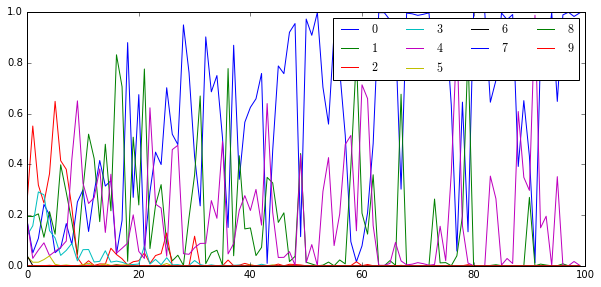

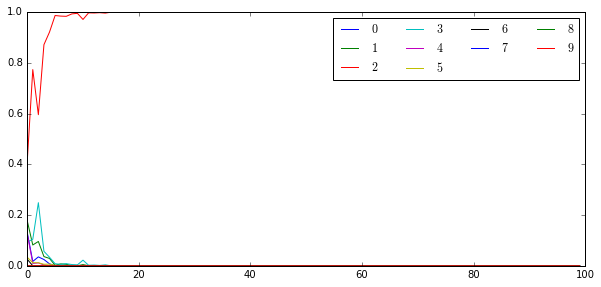

In [27]:
import matplotlib.pyplot as plt
import numpy as np

num_plots = 10

# Have a look at the colormaps here and decide which one you'd like:
# http://matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html
colormap = plt.cm.gist_ncar
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, num_plots)])

# Plot several different functions...
x = np.arange(10)
labels = []
plt.subplot(2, 1, 1)
for i in range(num_plots):
    plt.plot(range(len(list)), cccc[0,:,i])
    labels.append(r'$%i$' % (i))
plt.legend(labels, ncol=4, loc='upper right')
plt.show()
labels = []
plt.subplot(2, 1, 2)
for i in range(num_plots):
    plt.plot(range(len(list)), cccc[1,:,i])
    labels.append(r'$%i$' % (i))
plt.legend(labels, ncol=4, loc='upper right')

plt.show()